Wednesday, November 8, 2023

https://huggingface.co/docs/peft/task_guides/semantic_segmentation_lora

This all runs! Nice!

### Semantic segmentation using LoRA

This guide demonstrates how to use LoRA, a low-rank approximation technique, to finetune a SegFormer model variant for semantic segmentation. By using LoRA from 🤗 PEFT, we can reduce the number of trainable parameters in the SegFormer model to only 14% of the original trainable parameters.

LoRA achieves this reduction by adding low-rank “update matrices” to specific blocks of the model, such as the attention blocks. During fine-tuning, only these matrices are trained, while the original model parameters are left unchanged. At inference time, the update matrices are merged with the original model parameters to produce the final classification result.

For more information on LoRA, please refer to the [original LoRA paper](https://arxiv.org/abs/2106.09685).

In [1]:
import os
# target just the 4049 ...
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
from huggingface_hub import notebook_login

notebook_login()

#### Load a dataset

To ensure that this example runs within a reasonable time frame, here we are limiting the number of instances from the training set of the [SceneParse150 dataset](https://huggingface.co/datasets/scene_parse_150) to 150.

In [3]:
from datasets import load_dataset

ds = load_dataset("scene_parse_150", split="train[:150]")

Next, split the dataset into train and test sets.

In [4]:
ds = ds.train_test_split(test_size=0.1)
train_ds = ds["train"]
test_ds = ds["test"]

#### Prepare label maps

Create a dictionary that maps a label id to a label class, which will be useful when setting up the model later:

* label2id: maps the semantic classes of the dataset to integer ids.
* id2label: maps integer ids back to the semantic classes.

In [5]:
import json
from huggingface_hub import cached_download, hf_hub_url

repo_id = "huggingface/label-files"
filename = "ade20k-id2label.json"
id2label = json.load(open(cached_download(hf_hub_url(repo_id, filename, repo_type="dataset")), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}
num_labels = len(id2label)

/usr/local/lib/python3.8/dist-packages/huggingface_hub/file_download.py:659: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(


#### Prepare datasets for training and evaluation

Next, load the SegFormer image processor to prepare the images and annotations for the model. This dataset uses the zero-index as the background class, so make sure to set do_reduce_labels=True to subtract one from all labels since the background class is not among the 150 classes.

In [6]:
from transformers import AutoImageProcessor

checkpoint = "nvidia/mit-b0"
image_processor = AutoImageProcessor.from_pretrained(checkpoint, do_reduce_labels=True)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/transformers/src/transformers/models/segformer/image_processing_segformer.py:101: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


Add a function to apply data augmentation to the images, so that the model is more robust against overfitting. Here we use the ColorJitter function from torchvision to randomly change the color properties of an image.

In [7]:
from torchvision.transforms import ColorJitter

jitter = ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1)

Add a function to handle grayscale images and ensure that each input image has three color channels, regardless of whether it was originally grayscale or RGB. The function converts RGB images to array as is, and for grayscale images that have only one color channel, the function replicates the same channel three times using np.tile() before converting the image into an array.

In [8]:
import numpy as np

def handle_grayscale_image(image):
    np_image = np.array(image)
    if np_image.ndim == 2:
        tiled_image = np.tile(np.expand_dims(np_image, -1), 3)
        return Image.fromarray(tiled_image)
    else:
        return Image.fromarray(np_image)

Finally, combine everything in two functions that you’ll use to transform training and validation data. The two functions are similar except data augmentation is applied only to the training data.

In [9]:
from PIL import Image

def train_transforms(example_batch):
    images = [jitter(handle_grayscale_image(x)) for x in example_batch["image"]]
    labels = [x for x in example_batch["annotation"]]
    inputs = image_processor(images, labels)
    return inputs


def val_transforms(example_batch):
    images = [handle_grayscale_image(x) for x in example_batch["image"]]
    labels = [x for x in example_batch["annotation"]]
    inputs = image_processor(images, labels)
    return inputs

To apply the preprocessing functions over the entire dataset, use the 🤗 Datasets set_transform function:

In [10]:
%%time
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

CPU times: user 3.27 ms, sys: 0 ns, total: 3.27 ms
Wall time: 3.26 ms


#### Create evaluation function

Including a metric during training is helpful for evaluating your model’s performance. You can load an evaluation method with the [🤗 Evaluate library](https://huggingface.co/docs/evaluate/index). For this task, use the [mean Intersection over Union (IoU](https://huggingface.co/spaces/evaluate-metric/accuracy)) metric (see the 🤗 Evaluate [quick tour](https://huggingface.co/docs/evaluate/a_quick_tour) to learn more about how to load and compute a metric):

In [11]:
import torch
from torch import nn
import evaluate

metric = evaluate.load("mean_iou")

def compute_metrics(eval_pred):
    with torch.no_grad():
        logits, labels = eval_pred
        logits_tensor = torch.from_numpy(logits)
        logits_tensor = nn.functional.interpolate(
            logits_tensor,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).argmax(dim=1)

        pred_labels = logits_tensor.detach().cpu().numpy()
        # currently using _compute instead of compute
        # see this issue for more info: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
        metrics = metric._compute(
            predictions=pred_labels,
            references=labels,
            num_labels=len(id2label),
            ignore_index=0,
            reduce_labels=image_processor.do_reduce_labels,
        )

        per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
        per_category_iou = metrics.pop("per_category_iou").tolist()

        metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
        metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

        return metrics

#### Load a base model

Before loading a base model, let’s define a helper function to check the total number of parameters a model has, as well as how many of them are trainable.

In [12]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

Choose a base model checkpoint. For this example, we use the [SegFormer B0 variant](https://huggingface.co/nvidia/mit-b0). In addition to the checkpoint, pass the label2id and id2label dictionaries to let the AutoModelForSemanticSegmentation class know that we’re interested in a custom base model where the decoder head should be randomly initialized using the classes from the custom dataset.

In [13]:
from transformers import AutoModelForSemanticSegmentation, TrainingArguments, Trainer

model = AutoModelForSemanticSegmentation.from_pretrained(
    checkpoint, id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True
)
print_trainable_parameters(model)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.1.proj.weight', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_fuse.weight', 'decode_head.batch_norm.running_mean', 'decode_head.linear_c.0.proj.bias', 'decode_head.batch_norm.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.batch_norm.bias', 'decode_head.batch_norm.running_var', 'decode_head.linear_c.3.proj.bias', 'decode_head.classifier.bias', 'decode_head.linear_c.2.proj.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.2.proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 3752694 || all params: 3752694 || trainable%: 100.00


At this point you can check with the print_trainable_parameters helper function that all 100% parameters in the base model (aka model) are trainable.

#### Wrap the base model as a PeftModel for LoRA training

To leverage the LoRa method, you need to wrap the base model as a PeftModel. This involves two steps:

1) Defining LoRa configuration with LoraConfig
2) Wrapping the original model with get_peft_model() using the config defined in the step above.

In [14]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=32,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="lora_only",
    modules_to_save=["decode_head"],
)
lora_model = get_peft_model(model, config)
print_trainable_parameters(lora_model)

trainable params: 566422 || all params: 4317068 || trainable%: 13.12


Let’s review the LoraConfig. To enable LoRA technique, we must define the target modules within LoraConfig so that PeftModel can update the necessary matrices. Specifically, we want to target the query and value matrices in the attention blocks of the base model. These matrices are identified by their respective names, “query” and “value”. Therefore, we should specify these names in the target_modules argument of LoraConfig.

After we wrap our base model model with PeftModel along with the config, we get a new model where only the LoRA parameters are trainable (so-called “update matrices”) while the pre-trained parameters are kept frozen. These include the parameters of the randomly initialized classifier parameters too. This is NOT we want when fine-tuning the base model on our custom dataset. To ensure that the classifier parameters are also trained, we specify modules_to_save. This also ensures that these modules are serialized alongside the LoRA trainable parameters when using utilities like save_pretrained() and push_to_hub().

In addition to specifying the target_modules within LoraConfig, we also need to specify the modules_to_save. When we wrap our base model with PeftModel and pass the configuration, we obtain a new model in which only the LoRA parameters are trainable, while the pre-trained parameters and the randomly initialized classifier parameters are kept frozen. However, we do want to train the classifier parameters. By specifying the modules_to_save argument, we ensure that the classifier parameters are also trainable, and they will be serialized alongside the LoRA trainable parameters when we use utility functions like save_pretrained() and push_to_hub().

Let’s review the rest of the parameters:

* r: The dimension used by the LoRA update matrices.
* alpha: Scaling factor.
* bias: Specifies if the bias parameters should be trained. None denotes none of the bias parameters will be trained.

When all is configured, and the base model is wrapped, the print_trainable_parameters helper function lets us explore the number of trainable parameters. Since we’re interested in performing parameter-efficient fine-tuning, we should expect to see a lower number of trainable parameters from the lora_model in comparison to the original model which is indeed the case here.

You can also manually verify what modules are trainable in the lora_model.

In [15]:
for name, param in lora_model.named_parameters():
    if param.requires_grad:
        print(name, param.shape)

base_model.model.segformer.encoder.block.0.0.attention.self.query.bias torch.Size([32])
base_model.model.segformer.encoder.block.0.0.attention.self.query.lora_A.default.weight torch.Size([32, 32])
base_model.model.segformer.encoder.block.0.0.attention.self.query.lora_B.default.weight torch.Size([32, 32])
base_model.model.segformer.encoder.block.0.0.attention.self.value.bias torch.Size([32])
base_model.model.segformer.encoder.block.0.0.attention.self.value.lora_A.default.weight torch.Size([32, 32])
base_model.model.segformer.encoder.block.0.0.attention.self.value.lora_B.default.weight torch.Size([32, 32])
base_model.model.segformer.encoder.block.0.1.attention.self.query.bias torch.Size([32])
base_model.model.segformer.encoder.block.0.1.attention.self.query.lora_A.default.weight torch.Size([32, 32])
base_model.model.segformer.encoder.block.0.1.attention.self.query.lora_B.default.weight torch.Size([32, 32])
base_model.model.segformer.encoder.block.0.1.attention.self.value.bias torch.Size(

This confirms that only the LoRA parameters appended to the attention blocks and the decode_head parameters are trainable.

#### Train the model

Start by defining your training hyperparameters in TrainingArguments. You can change the values of most parameters however you prefer. Make sure to set remove_unused_columns=False, otherwise the image column will be dropped, and it’s required here. The only other required parameter is output_dir which specifies where to save your model. At the end of each epoch, the Trainer will evaluate the IoU metric and save the training checkpoint.

Note that this example is meant to walk you through the workflow when using PEFT for semantic segmentation. We didn’t perform extensive hyperparameter tuning to achieve optimal results.

In [16]:
model_name = checkpoint.split("/")[-1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-scene-parse-150-lora",
    learning_rate=5e-4,
    num_train_epochs=50,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=2,
    save_total_limit=3,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=5,
    remove_unused_columns=False,
    push_to_hub=True,
    label_names=["labels"],
)

Pass the training arguments to Trainer along with the model, dataset, and compute_metrics function. Call train() to finetune your model.

In [17]:
trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

CODECARBON : No CPU tracking mode found. Falling back on CPU constant mode.


In [18]:
%%time
trainer.train()

# CPU times: user 18min 30s, sys: 43.8 s, total: 19min 14s
# Wall time: 7min 27s

Epoch,Training Loss,Validation Loss,Mean Iou,Mean Accuracy,Overall Accuracy,Accuracy Wall,Accuracy Building,Accuracy Sky,Accuracy Floor,Accuracy Tree,Accuracy Ceiling,Accuracy Road,Accuracy Bed,Accuracy Windowpane,Accuracy Grass,Accuracy Cabinet,Accuracy Sidewalk,Accuracy Person,Accuracy Earth,Accuracy Door,Accuracy Table,Accuracy Mountain,Accuracy Plant,Accuracy Curtain,Accuracy Chair,Accuracy Car,Accuracy Water,Accuracy Painting,Accuracy Sofa,Accuracy Shelf,Accuracy House,Accuracy Sea,Accuracy Mirror,Accuracy Rug,Accuracy Field,Accuracy Armchair,Accuracy Seat,Accuracy Fence,Accuracy Desk,Accuracy Rock,Accuracy Wardrobe,Accuracy Lamp,Accuracy Bathtub,Accuracy Railing,Accuracy Cushion,Accuracy Base,Accuracy Box,Accuracy Column,Accuracy Signboard,Accuracy Chest of drawers,Accuracy Counter,Accuracy Sand,Accuracy Sink,Accuracy Skyscraper,Accuracy Fireplace,Accuracy Refrigerator,Accuracy Grandstand,Accuracy Path,Accuracy Stairs,Accuracy Runway,Accuracy Case,Accuracy Pool table,Accuracy Pillow,Accuracy Screen door,Accuracy Stairway,Accuracy River,Accuracy Bridge,Accuracy Bookcase,Accuracy Blind,Accuracy Coffee table,Accuracy Toilet,Accuracy Flower,Accuracy Book,Accuracy Hill,Accuracy Bench,Accuracy Countertop,Accuracy Stove,Accuracy Palm,Accuracy Kitchen island,Accuracy Computer,Accuracy Swivel chair,Accuracy Boat,Accuracy Bar,Accuracy Arcade machine,Accuracy Hovel,Accuracy Bus,Accuracy Towel,Accuracy Light,Accuracy Truck,Accuracy Tower,Accuracy Chandelier,Accuracy Awning,Accuracy Streetlight,Accuracy Booth,Accuracy Television receiver,Accuracy Airplane,Accuracy Dirt track,Accuracy Apparel,Accuracy Pole,Accuracy Land,Accuracy Bannister,Accuracy Escalator,Accuracy Ottoman,Accuracy Bottle,Accuracy Buffet,Accuracy Poster,Accuracy Stage,Accuracy Van,Accuracy Ship,Accuracy Fountain,Accuracy Conveyer belt,Accuracy Canopy,Accuracy Washer,Accuracy Plaything,Accuracy Swimming pool,Accuracy Stool,Accuracy Barrel,Accuracy Basket,Accuracy Waterfall,Accuracy Tent,Accuracy Bag,Accuracy Minibike,Accuracy Cradle,Accuracy Oven,Accuracy Ball,Accuracy Food,Accuracy Step,Accuracy Tank,Accuracy Trade name,Accuracy Microwave,Accuracy Pot,Accuracy Animal,Accuracy Bicycle,Accuracy Lake,Accuracy Dishwasher,Accuracy Screen,Accuracy Blanket,Accuracy Sculpture,Accuracy Hood,Accuracy Sconce,Accuracy Vase,Accuracy Traffic light,Accuracy Tray,Accuracy Ashcan,Accuracy Fan,Accuracy Pier,Accuracy Crt screen,Accuracy Plate,Accuracy Monitor,Accuracy Bulletin board,Accuracy Shower,Accuracy Radiator,Accuracy Glass,Accuracy Clock,Accuracy Flag,Iou Wall,Iou Building,Iou Sky,Iou Floor,Iou Tree,Iou Ceiling,Iou Road,Iou Bed,Iou Windowpane,Iou Grass,Iou Cabinet,Iou Sidewalk,Iou Person,Iou Earth,Iou Door,Iou Table,Iou Mountain,Iou Plant,Iou Curtain,Iou Chair,Iou Car,Iou Water,Iou Painting,Iou Sofa,Iou Shelf,Iou House,Iou Sea,Iou Mirror,Iou Rug,Iou Field,Iou Armchair,Iou Seat,Iou Fence,Iou Desk,Iou Rock,Iou Wardrobe,Iou Lamp,Iou Bathtub,Iou Railing,Iou Cushion,Iou Base,Iou Box,Iou Column,Iou Signboard,Iou Chest of drawers,Iou Counter,Iou Sand,Iou Sink,Iou Skyscraper,Iou Fireplace,Iou Refrigerator,Iou Grandstand,Iou Path,Iou Stairs,Iou Runway,Iou Case,Iou Pool table,Iou Pillow,Iou Screen door,Iou Stairway,Iou River,Iou Bridge,Iou Bookcase,Iou Blind,Iou Coffee table,Iou Toilet,Iou Flower,Iou Book,Iou Hill,Iou Bench,Iou Countertop,Iou Stove,Iou Palm,Iou Kitchen island,Iou Computer,Iou Swivel chair,Iou Boat,Iou Bar,Iou Arcade machine,Iou Hovel,Iou Bus,Iou Towel,Iou Light,Iou Truck,Iou Tower,Iou Chandelier,Iou Awning,Iou Streetlight,Iou Booth,Iou Television receiver,Iou Airplane,Iou Dirt track,Iou Apparel,Iou Pole,Iou Land,Iou Bannister,Iou Escalator,Iou Ottoman,Iou Bottle,Iou Buffet,Iou Poster,Iou Stage,Iou Van,Iou Ship,Iou Fountain,Iou Conveyer belt,Iou Canopy,Iou Washer,Iou Plaything,Iou Swimming pool,Iou Stool,Iou Barrel,Iou Basket,Iou Waterfall,Iou Tent,Iou Bag,Iou Minibike,Iou Cradle,Iou Oven,Iou Ball,Iou Food,Iou Step,Iou Tank,Iou Trade name,Iou Microwave,Iou Pot,Iou Animal,

/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encoun

CPU times: user 18min 30s, sys: 43.8 s, total: 19min 14s
Wall time: 7min 27s


TrainOutput(global_step=1700, training_loss=1.0477720503246084, metrics={'train_runtime': 443.641, 'train_samples_per_second': 15.215, 'train_steps_per_second': 3.832, 'total_flos': 1.37500757065728e+17, 'train_loss': 1.0477720503246084, 'epoch': 50.0})

#### Save the model and run inference

Use the save_pretrained() method of the lora_model to save the LoRA-only parameters locally. Alternatively, use the push_to_hub() method to upload these parameters directly to the Hugging Face Hub (as shown in the [Image classification using LoRA](https://huggingface.co/docs/peft/task_guides/image_classification_lora) task guide).

In [19]:
model_id = "segformer-scene-parse-150-lora"

lora_model.save_pretrained(model_id)

We can see that the LoRA-only parameters are just 2.2 MB in size! This greatly improves the portability when using very large models.

In [20]:
!ls -lh {model_id}
# total 2.2M
# -rw-r--r-- 1 root root  369 Feb  8 03:09 adapter_config.json
# -rw-r--r-- 1 root root 2.2M Feb  8 03:09 adapter_model.bin

total 2.2M
-rw-r--r-- 1 root root 5.0K Nov  8 16:31 README.md
-rw-r--r-- 1 root root  629 Nov  8 16:31 adapter_config.json
-rw-r--r-- 1 root root 2.2M Nov  8 16:31 adapter_model.bin


Let’s now prepare an inference_model and run inference.

In [22]:
from peft import PeftConfig, PeftModel

config = PeftConfig.from_pretrained(model_id)
model = AutoModelForSemanticSegmentation.from_pretrained(
    checkpoint, id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True
)

inference_model = PeftModel.from_pretrained(model, model_id)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.1.proj.weight', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_fuse.weight', 'decode_head.batch_norm.running_mean', 'decode_head.linear_c.0.proj.bias', 'decode_head.batch_norm.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.batch_norm.bias', 'decode_head.batch_norm.running_var', 'decode_head.linear_c.3.proj.bias', 'decode_head.classifier.bias', 'decode_head.linear_c.2.proj.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.2.proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Get an image:

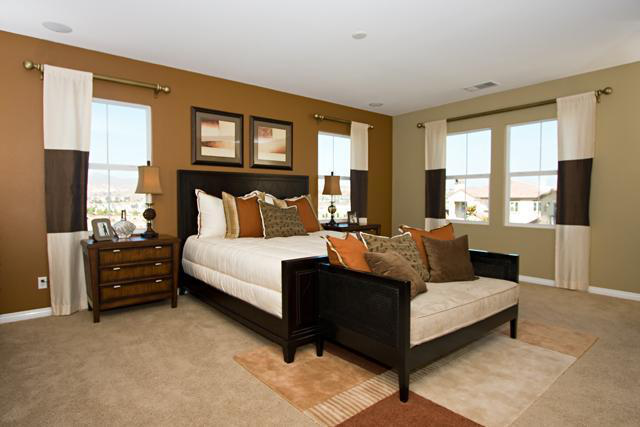

In [23]:
import requests

url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/semantic-seg-image.png"
image = Image.open(requests.get(url, stream=True).raw)
image

Preprocess the image to prepare for inference.

In [24]:
encoding = image_processor(image.convert("RGB"), return_tensors="pt")

Run inference with the encoded image.

In [25]:
with torch.no_grad():
    outputs = inference_model(pixel_values=encoding.pixel_values)
    logits = outputs.logits

upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

pred_seg = upsampled_logits.argmax(dim=1)[0]

Next, visualize the results. We need a color palette for this. Here, we use ade_palette(). As it is a long array, so we don’t include it in this guide, please copy it from the [TensorFlow Model Garden repository](https://github.com/tensorflow/models/blob/3f1ca33afe3c1631b733ea7e40c294273b9e406d/research/deeplab/utils/get_dataset_colormap.py#L51).



In [26]:
def create_ade20k_label_colormap():
  """Creates a label colormap used in ADE20K segmentation benchmark.

  Returns:
    A colormap for visualizing segmentation results.
  """
  return np.asarray([
      [0, 0, 0],
      [120, 120, 120],
      [180, 120, 120],
      [6, 230, 230],
      [80, 50, 50],
      [4, 200, 3],
      [120, 120, 80],
      [140, 140, 140],
      [204, 5, 255],
      [230, 230, 230],
      [4, 250, 7],
      [224, 5, 255],
      [235, 255, 7],
      [150, 5, 61],
      [120, 120, 70],
      [8, 255, 51],
      [255, 6, 82],
      [143, 255, 140],
      [204, 255, 4],
      [255, 51, 7],
      [204, 70, 3],
      [0, 102, 200],
      [61, 230, 250],
      [255, 6, 51],
      [11, 102, 255],
      [255, 7, 71],
      [255, 9, 224],
      [9, 7, 230],
      [220, 220, 220],
      [255, 9, 92],
      [112, 9, 255],
      [8, 255, 214],
      [7, 255, 224],
      [255, 184, 6],
      [10, 255, 71],
      [255, 41, 10],
      [7, 255, 255],
      [224, 255, 8],
      [102, 8, 255],
      [255, 61, 6],
      [255, 194, 7],
      [255, 122, 8],
      [0, 255, 20],
      [255, 8, 41],
      [255, 5, 153],
      [6, 51, 255],
      [235, 12, 255],
      [160, 150, 20],
      [0, 163, 255],
      [140, 140, 140],
      [250, 10, 15],
      [20, 255, 0],
      [31, 255, 0],
      [255, 31, 0],
      [255, 224, 0],
      [153, 255, 0],
      [0, 0, 255],
      [255, 71, 0],
      [0, 235, 255],
      [0, 173, 255],
      [31, 0, 255],
      [11, 200, 200],
      [255, 82, 0],
      [0, 255, 245],
      [0, 61, 255],
      [0, 255, 112],
      [0, 255, 133],
      [255, 0, 0],
      [255, 163, 0],
      [255, 102, 0],
      [194, 255, 0],
      [0, 143, 255],
      [51, 255, 0],
      [0, 82, 255],
      [0, 255, 41],
      [0, 255, 173],
      [10, 0, 255],
      [173, 255, 0],
      [0, 255, 153],
      [255, 92, 0],
      [255, 0, 255],
      [255, 0, 245],
      [255, 0, 102],
      [255, 173, 0],
      [255, 0, 20],
      [255, 184, 184],
      [0, 31, 255],
      [0, 255, 61],
      [0, 71, 255],
      [255, 0, 204],
      [0, 255, 194],
      [0, 255, 82],
      [0, 10, 255],
      [0, 112, 255],
      [51, 0, 255],
      [0, 194, 255],
      [0, 122, 255],
      [0, 255, 163],
      [255, 153, 0],
      [0, 255, 10],
      [255, 112, 0],
      [143, 255, 0],
      [82, 0, 255],
      [163, 255, 0],
      [255, 235, 0],
      [8, 184, 170],
      [133, 0, 255],
      [0, 255, 92],
      [184, 0, 255],
      [255, 0, 31],
      [0, 184, 255],
      [0, 214, 255],
      [255, 0, 112],
      [92, 255, 0],
      [0, 224, 255],
      [112, 224, 255],
      [70, 184, 160],
      [163, 0, 255],
      [153, 0, 255],
      [71, 255, 0],
      [255, 0, 163],
      [255, 204, 0],
      [255, 0, 143],
      [0, 255, 235],
      [133, 255, 0],
      [255, 0, 235],
      [245, 0, 255],
      [255, 0, 122],
      [255, 245, 0],
      [10, 190, 212],
      [214, 255, 0],
      [0, 204, 255],
      [20, 0, 255],
      [255, 255, 0],
      [0, 153, 255],
      [0, 41, 255],
      [0, 255, 204],
      [41, 0, 255],
      [41, 255, 0],
      [173, 0, 255],
      [0, 245, 255],
      [71, 0, 255],
      [122, 0, 255],
      [0, 255, 184],
      [0, 92, 255],
      [184, 255, 0],
      [0, 133, 255],
      [255, 214, 0],
      [25, 194, 194],
      [102, 255, 0],
      [92, 0, 255],
  ])

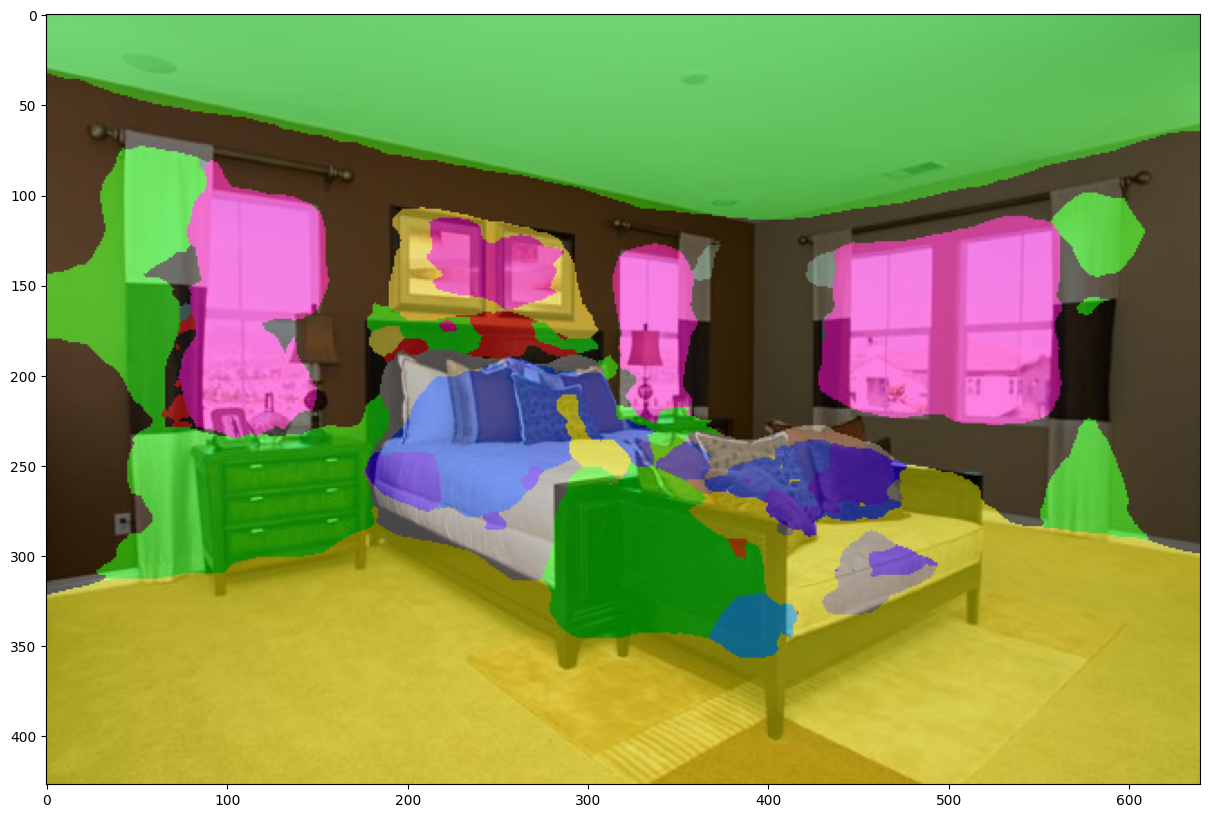

In [27]:
import matplotlib.pyplot as plt

color_seg = np.zeros((pred_seg.shape[0], pred_seg.shape[1], 3), dtype=np.uint8)
# palette = np.array(ade_palette())
palette = np.array(create_ade20k_label_colormap())

for label, color in enumerate(palette):
    color_seg[pred_seg == label, :] = color
color_seg = color_seg[..., ::-1]  # convert to BGR

img = np.array(image) * 0.5 + color_seg * 0.5  # plot the image with the segmentation map
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

As you can see, the results are far from perfect, however, this example is designed to illustrate the end-to-end workflow of fine-tuning a semantic segmentation model with LoRa technique, and is not aiming to achieve state-of-the-art results. The results you see here are the same as you would get if you performed full fine-tuning on the same setup (same model variant, same dataset, same training schedule, etc.), except LoRA allows to achieve them with a fraction of total trainable parameters and in less time.

If you wish to use this example and improve the results, here are some things that you can try:

* Increase the number of training samples.
* Try a larger SegFormer model variant (explore available model variants on the Hugging Face Hub).
* Try different values for the arguments available in LoraConfig.
* Tune the learning rate and batch size.